In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


In this notebook, we look at the $\mathcal{M}$-open setting, where the generating process is in the span of models.

# Generate a random matrices V, W

For V, assume that 12 variables share a factor structure and the other 8 are noise

In [2]:
N = 50000
D_factor = 10
D_noise = 10
P = 3

V = np.abs(np.random.normal(0.5, 0.5, size=(P,D_factor)))
Z = np.abs(np.random.normal(0.5, size=(N,P)))

ZV = Z.dot(V)

X = np.zeros((N, D_factor*2))
X[:, ::2] = np.random.poisson(ZV)
X[:, 1::2] = np.random.poisson(2.,size=(N,D_factor))

In [3]:
# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)

In [4]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    scale_rates=True, 
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 20 -> Latent dim 3


In [5]:
losses = factor.calibrate_advi(
    num_epochs=100, learning_rate=.1)



W0520 14:16:20.147902 4476612032 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 51.64505200720985
Epoch 1: average-batch loss: 32.27218748027601 last batch loss: 31.238830248493517
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 30.268660539625067 last batch loss: 30.209161031833553
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 29.43800255475942 last batch loss: 29.638527090520178
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 29.15980225037406 last batch loss: 29.496205180510803
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 29.08941057290569 last batch loss: 29.42538579153719
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 29.051820838094226 last batch loss: 29.40957732457581
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 29.02460791015364 last batch loss: 29.363294907885823
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 29.00243388829496 last batch loss: 29.362881693569257
Saved a checkpoint: ./.t

Epoch 70: average-batch loss: 28.78965511290864 last batch loss: 29.16326772038462
Saved a checkpoint: ./.tf_ckpts/chkpt-43
Epoch 71: average-batch loss: 28.790350453424924 last batch loss: 29.132449249158128
Epoch 72: average-batch loss: 28.795250384595903 last batch loss: 29.16974837428143
We are in a loss plateau learning rate: 4.8828125e-05 loss: 28.466607630818455
Restoring from a checkpoint - loss: 28.473686700792907
Epoch 73: average-batch loss: 28.78826108966842 last batch loss: 29.146674918908815
Saved a checkpoint: ./.tf_ckpts/chkpt-44
Epoch 74: average-batch loss: 28.793268736321632 last batch loss: 29.156785258586716
Epoch 75: average-batch loss: 28.790503984500788 last batch loss: 29.173449000781993
Epoch 76: average-batch loss: 28.790454779748117 last batch loss: 29.179216314706384
Epoch 77: average-batch loss: 28.795916451704414 last batch loss: 29.20276706165173
We are in a loss plateau learning rate: 1.220703125e-05 loss: 28.48106669051757
Restoring from a checkpoint -

In [6]:
waic = factor.waic()
print(waic)

{'waic': 223986.728997907, 'se': 1658.3351721553738, 'lppd': -27156.324094612384, 'pwaic': 84837.04040434111}


In [7]:
intercept_data = az.convert_to_inference_data(
    {
        r"$s_dw_d$": tf.squeeze(
            factor.surrogate_distribution.sample(1000)['w']*factor.norm_factor).numpy().T})

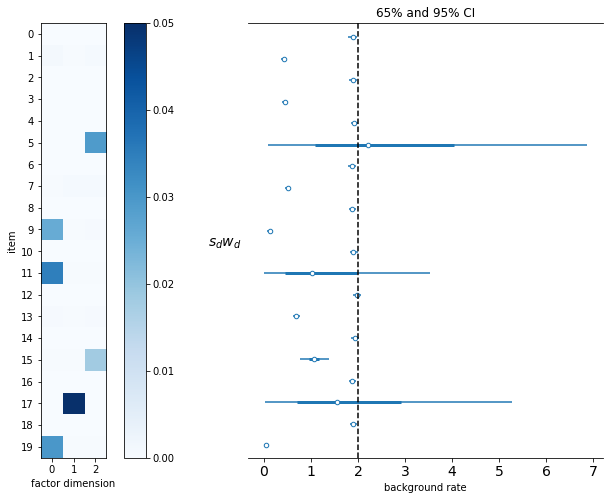

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
D = factor.feature_dim
pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(2.0, linestyle='dashed', color="black")
plt.savefig('mix_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()
